In [45]:
import numpy as np
import scanpy as sc
import torch
import pandas as pd
import scipy

In [46]:
adata = sc.read_csv('/home/wtu/su/code/data/synthetic/guo2010Data.csv', delimiter=',', first_column_names='Gene', dtype='float32')
# adata = adata.T
adata = adata.T
adata

/home/wtu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wtu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 438 × 48

In [47]:
adata.obs

""
1C 1
1C 2
1C 3
1C 4
1C 5
...
64C 7.10
64C 7.11
64C 7.12
64C 7.13


In [48]:
# Import guo2010Datalabels
datasets_names = 'guo2010'
obs = pd.read_csv('/home/wtu/su/code/data/synthetic/guo2010Datalabels.csv',delimiter=',')
obs

,stage
0,1
1,1
2,1
3,1
4,1
...,...
433,7
434,7
435,7
436,7


In [49]:
# adata.obs['assigned_cluster'] = obs
ture_stage = obs.stage
ture_stage

0      1
1      1
2      1
3      1
4      1
      ..
433    7
434    7
435    7
436    7
437    7
Name: stage, Length: 438, dtype: int64

## 1 The cell-state latent space is obtained from single-cell data.

In [50]:
filtered_df = pd.DataFrame(data=adata.to_df())
data = sc.AnnData(filtered_df)
filtered_df.shape  # (649, 16122)

/home/wtu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(438, 48)

In [51]:
from margaret.utils.util import run_pca
# 计算效率计算
import time
start1 = time.time()

# Apply PCA on the raw data for initial denoising #应用pca产生初始指标
print('Computing PCA...')
X_pca, va, n_comps = run_pca(data, use_hvg=False, n_components=30)
data.obsm['X_pca'] = X_pca #data: Any = sc.AnnData(filtered_df)
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 0.0032777786254882812
Components computed: 30


In [52]:
import warnings # 警告信息的控制
from margaret.train_metric import train_metric_learner

with warnings.catch_warnings():
    # Filter out user warnings from PyTorch about saving scheduler state
    # 过滤掉PyTorch中关于保存调度程序状态的用户警告
    warnings.simplefilter("ignore")
    train_metric_learner(data, n_episodes=5, n_metric_epochs=30, obsm_data_key='X_pca', code_size=5,
        backend='leiden', device='cuda', save_path='./content/metric/news'+datasets_names+'chkpt',
        cluster_kwargs={'random_state': 0, 'resolution': 1.0}, nn_kwargs={'random_state': 0, 'n_neighbors': 50},
        trainer_kwargs={'optimizer': 'SGD', 'lr': 0.01, 'batch_size': 256}
    )
    
start2 = time.time()

Generating initial clusters
Runtime for determine_cell_clusters(): 0.07928276062011719
Training for episode: 1


100%|██████████| 438/438 [00:00<00:00, 3148.69it/s]


Re-generating clusters for episode: 1
Runtime for determine_cell_clusters(): 0.07743573188781738
Time Elapsed for epoch: 3.9099643230438232s
Training for episode: 2


100%|██████████| 438/438 [00:00<00:00, 3141.81it/s]


Re-generating clusters for episode: 2
Runtime for determine_cell_clusters(): 0.05672001838684082
Time Elapsed for epoch: 4.005155324935913s
Training for episode: 3


100%|██████████| 438/438 [00:00<00:00, 3787.98it/s]


Re-generating clusters for episode: 3
Runtime for determine_cell_clusters(): 0.05407404899597168
Time Elapsed for epoch: 3.9452028274536133s
Training for episode: 4


100%|██████████| 438/438 [00:00<00:00, 3513.44it/s]


Re-generating clusters for episode: 4
Runtime for determine_cell_clusters(): 0.07514357566833496
Time Elapsed for epoch: 4.080127954483032s
Training for episode: 5


100%|██████████| 438/438 [00:00<00:00, 3649.46it/s]

Re-generating clusters for episode: 5
Runtime for determine_cell_clusters(): 0.05780959129333496
Time Elapsed for epoch: 4.018662691116333s
Runtime for train_metric_learner(): 20.04502582550049


In [53]:
# 输出低维流形
m_embedding = data.obsm["metric_embedding"]
m_embedding.shape

(438, 5)

In [54]:
m_communities = data.obs['metric_clusters'].to_numpy().astype(np.int)
m_communities

/tmp/ipykernel_19557/2273883432.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m_communities = data.obs['metric_clusters'].to_numpy().astype(np.int)


array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 4, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 4, 3, 0, 0, 3, 3,
       4, 3, 3, 5, 4, 4, 5, 4, 3, 3, 5, 3, 3, 5, 3, 4, 4, 4, 3, 3, 4, 2,
       3, 4, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 3, 5, 5,
       3, 4, 4, 4, 3, 4, 4, 3, 3, 5, 4, 4, 4, 3, 3, 3, 4, 3, 4, 4, 3, 4,
       2, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 0, 4, 4, 3, 4, 0, 4, 4, 3, 4, 4,
       3, 4, 4, 4, 3, 0, 0, 3, 3, 0, 4, 0, 2, 3, 4, 5, 0, 3, 5, 5, 3, 5,
       0, 5, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 3,

datasets_shape:  (438, 48)
umap_embedding_shape: (438, 2)


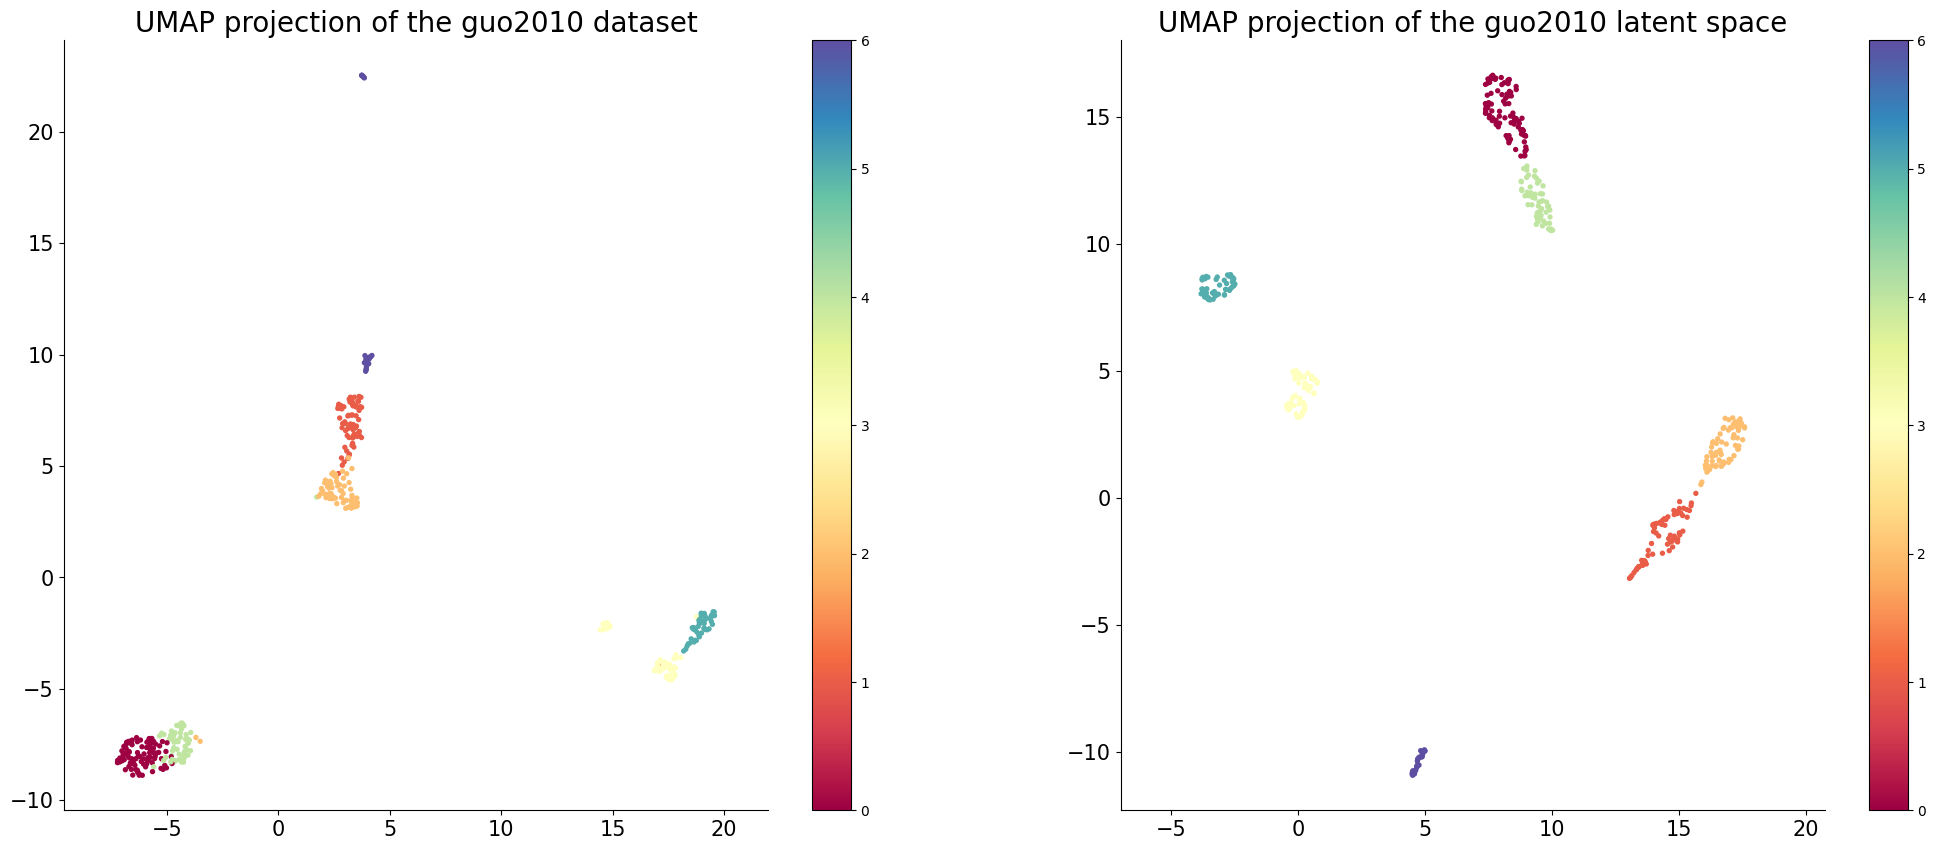

In [55]:
##############################################
# 数据导入
# data = m_embedding
import matplotlib.pyplot as plt
# plt.style.use(["seaborn-darkgrid", "seaborn-colorblind", "seaborn-notebook"])
plt.style.use('default')
datasets = adata.X
print('datasets_shape: ',datasets.shape)

fig1 = plt.figure(figsize=(25,10))

import umap
import matplotlib.pyplot as plt
# the original data space
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(datasets)
print('umap_embedding_shape:',umap_embedding.shape)
plt.subplot(121)
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=m_communities, cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar()
plt.title('UMAP projection of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

# the cell-state latent space
embedding = reducer.fit_transform(m_embedding)

plt.subplot(122)
plt.scatter(embedding[:, 0], embedding[:, 1], c=m_communities, cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(6))
plt.colorbar()
plt.title('UMAP projection of the '+datasets_names+' latent space',fontdict={'weight':'normal','size': 20})


plt.savefig("./result/figure/2"+datasets_names+"_01latent spatial visualization.png")  #保存图片
plt.savefig("./result/pdf/2"+datasets_names+"_01latent spatial visualization.pdf")  #保存图片
plt.show()

## 2 Trajectory modeling is based on stochastic probability model.

In [56]:

import time
from DTFLOW import *
start3 = time.time()

z = DTFLOW(m_embedding,m_communities)

M = z.get_transition_matrix(10)
S = z.get_diffusionRWR(p=0.9)
Y = z.get_Y(slover='SVD',dim=2)
print(Y.shape)
# margaret部分
end1 = time.time()
print (datasets_names+'our运行时间：',str(end1-start3+start2-start1))  # 149.7596480846405
print (datasets_names+'our_dtflow运行时间：',str(end1-start3)) 

(438, 2)
guo2010our运行时间： 20.27285933494568
guo2010our_dtflow运行时间： 0.0803835391998291


### 2.1 Trajectory visualization is based on the real stage

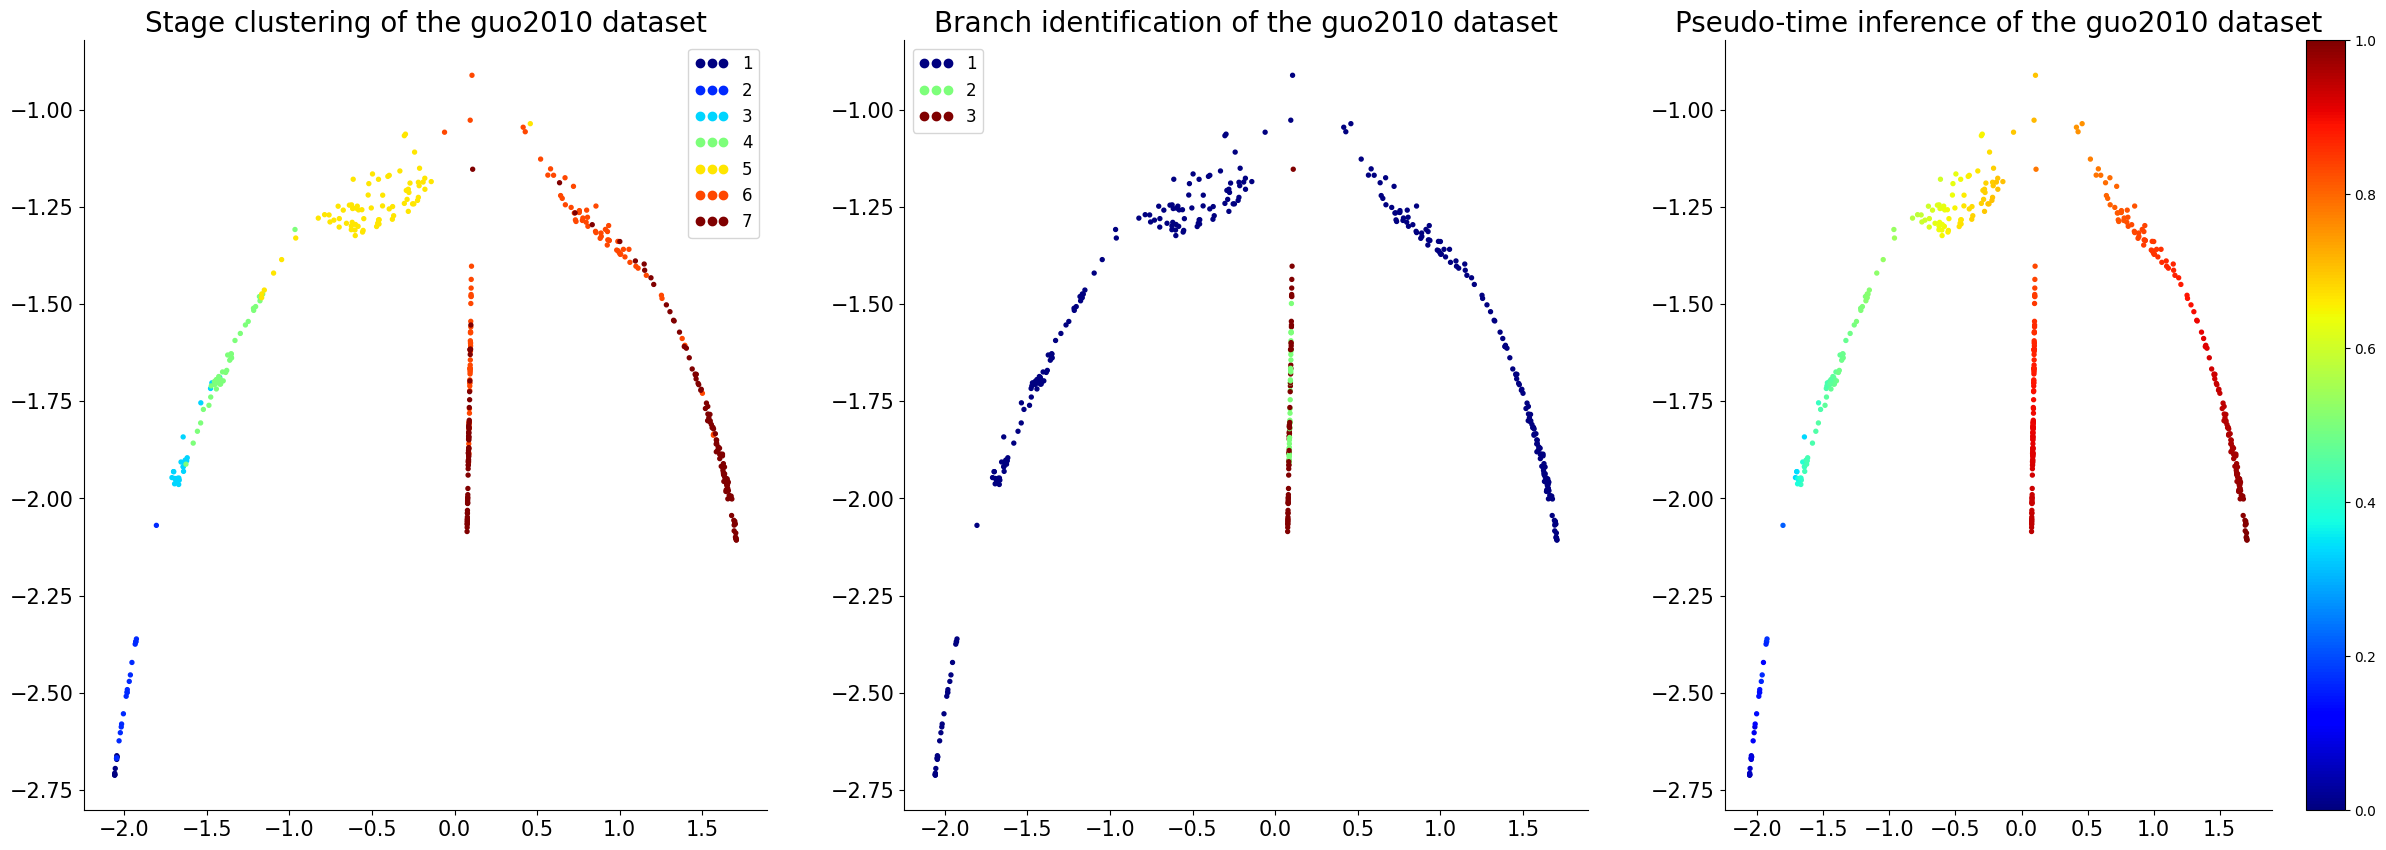

In [57]:
dims=[0,1]
plt.style.use('default')
fig = plt.figure(figsize=(30,10))

stages = ture_stage
time_stage = sorted(set(stages))
color_stage = cm.jet(np.linspace(0, 1, len(time_stage)))
color_dict = dict(zip(time_stage, color_stage[:len(time_stage)]))
sc_colors1 = [color_dict[cst] for cst in stages]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(131)  # 子图1阶段
# ax = plt.gca()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors1,s=8)
plt.legend(markers, color_dict.keys(), loc='best', numpoints=3,fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.gca().set_axis_off()
# plt.grid(False)

plt.title('Stage clustering of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

# 计算伪时间
# print('stages:',stages)
root_list = list(np.where(stages == 1)[0])  # 对应标签中的起始阶段
# print('root_list',root_list)
dftimes_ml = z.get_dtflow_times(root_list)
np.savetxt("./result/execl/3"+datasets_names+"_01mlbkfd pseudotime.csv",dftimes_ml,delimiter=',')
# z.plotY(size=(10,10),dims=[0,1],color ='dftime')

# 计算分支
branch = z.get_branches(Num=11,delta = 0.9) # 1-11 12-112 #11, 12-112 

# 子图3，4
plt.subplot(133) 
p = plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c= dftimes_ml, s=8, cmap='jet')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(p)

plt.title('Pseudo-time inference of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

nums_branch = sorted(set(branch)) 
color_branch = cm.jet(np.linspace(0, 1, len(nums_branch)))
color_dict = dict(zip(nums_branch,color_branch[:len(nums_branch)]))
sc_colors = [color_dict[cst] for cst in branch]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(132)  # 子图2分支
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors,s=8)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
plt.title('Branch identification of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})
# plt.savefig('./figures/1'+datasets_names+' dataset/1')   #保存图片
plt.savefig("./result/figure/2"+datasets_names+"_02_MLBKFD_based on the real stage.png")
plt.savefig("./result/pdf/2"+datasets_names+"_02_MLBKFD_based on the real stage.pdf")
plt.show()

### 2.2 Trajectory visualization is based on this method stage

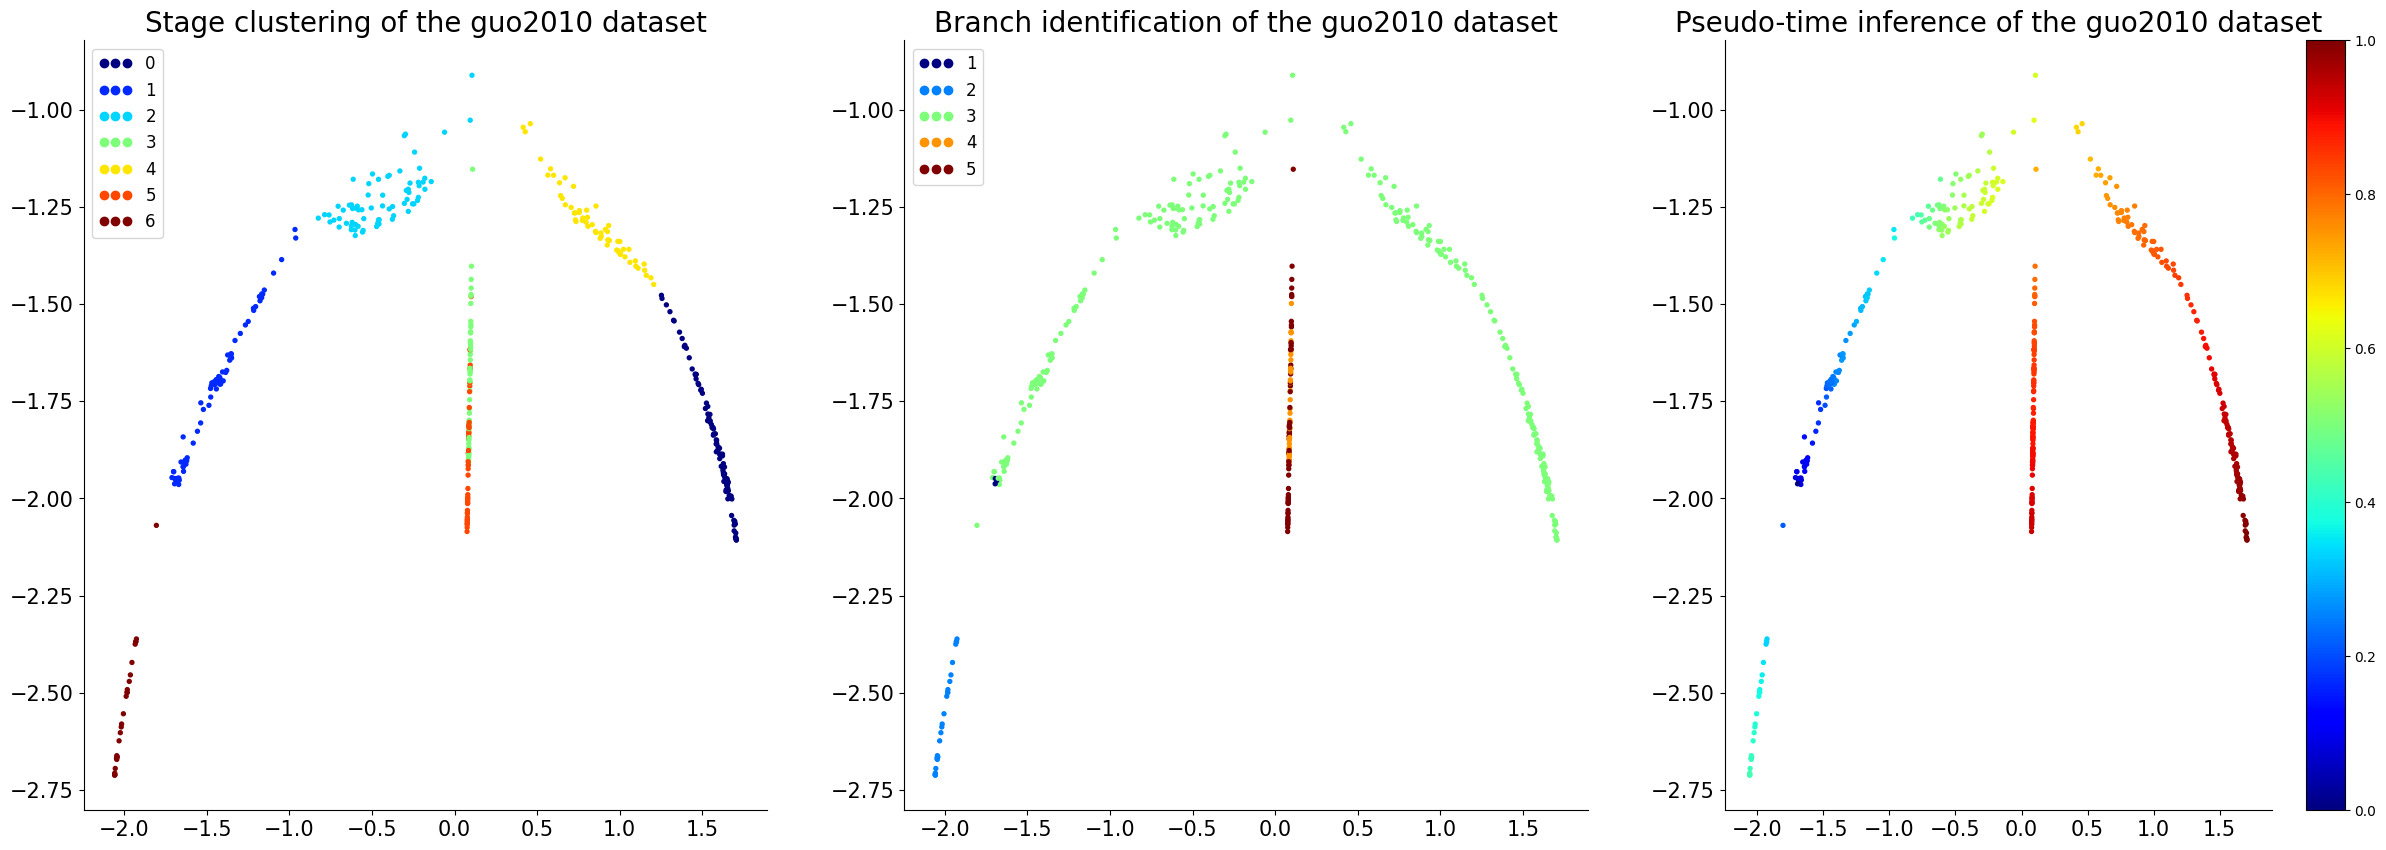

In [58]:
dims=[0,1]
fig = plt.figure(figsize=(30,10))


stages = m_communities
time_stage = sorted(set(stages))
color_stage = cm.jet(np.linspace(0, 1, len(time_stage)))
color_dict = dict(zip(time_stage, color_stage[:len(time_stage)]))
sc_colors1 = [color_dict[cst] for cst in stages]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(131)  # 子图1阶段
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors1,s=8)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Stage clustering of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

# 计算伪时间
root_list = list(np.where(m_communities == 1)[0])
dftimes = z.get_dtflow_times(root_list)
np.savetxt("./result/execl/3"+datasets_names+"_02mlbkfd0 pseudotime.csv",dftimes,delimiter=',')
# z.plotY(size=(10,10),dims=[0,1],color ='dftime')

# 计算分支
branch = z.get_branches(Num=11,delta = 0.9) # 1-11 12-112 #11, 12-112 
# 子图3，4
plt.subplot(133) 
p = plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c= dftimes, s=8, cmap='jet')
plt.colorbar(p)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Pseudo-time inference of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})

nums_branch = sorted(set(branch)) 
color_branch = cm.jet(np.linspace(0, 1, len(nums_branch)))
color_dict = dict(zip(nums_branch,color_branch[:len(nums_branch)]))
sc_colors = [color_dict[cst] for cst in branch]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(132)  # 子图2分支
plt.scatter(Y[:,dims[0]],Y[:,dims[1]], c=sc_colors,s=8)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Branch identification of the '+datasets_names+' dataset',fontdict={'weight':'normal','size': 20})
# plt.savefig('./figures/1'+datasets_names+' dataset/1')   #保存图片
plt.savefig("./result/figure/2"+datasets_names+"_03Trajectory visualization is based on this method stage.png")
plt.savefig("./result/pdf/2"+datasets_names+"_03Trajectory visualization is based on this method stage.pdf")
plt.show()

## 纯DTFLOW计算的时间

In [59]:
import scipy as sp
import sys

time_stages = data.obs['metric_clusters'].to_numpy().astype(np.int)
# timeture_stages =np.loadtxt('pns_development_stage.txt',dtype=np.float32)

raw_df = adata.X

cell_names = data.obs
gene_names = data.var

raw_df.shape

# 计算效率计算
import time
start_d1 = time.time()

# 
dz = DTFLOW(raw_df,time_stages)
dz = DTFLOW(raw_df,time_stages)
dM = dz.get_transition_matrix(10)
dS = dz.get_diffusionRWR(p=0.9)

dY = dz.get_Y(slover='SVD',dim=2)
# z.plotY(size=(10,10),dims=[0,1],color ='stages')

# DTFLOW部分
end2 = time.time()

print (datasets_names+'dtflow运行时间：',str(end2-start_d1))  #

/tmp/ipykernel_19557/431240463.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time_stages = data.obs['metric_clusters'].to_numpy().astype(np.int)


guo2010dtflow运行时间： 0.27036261558532715


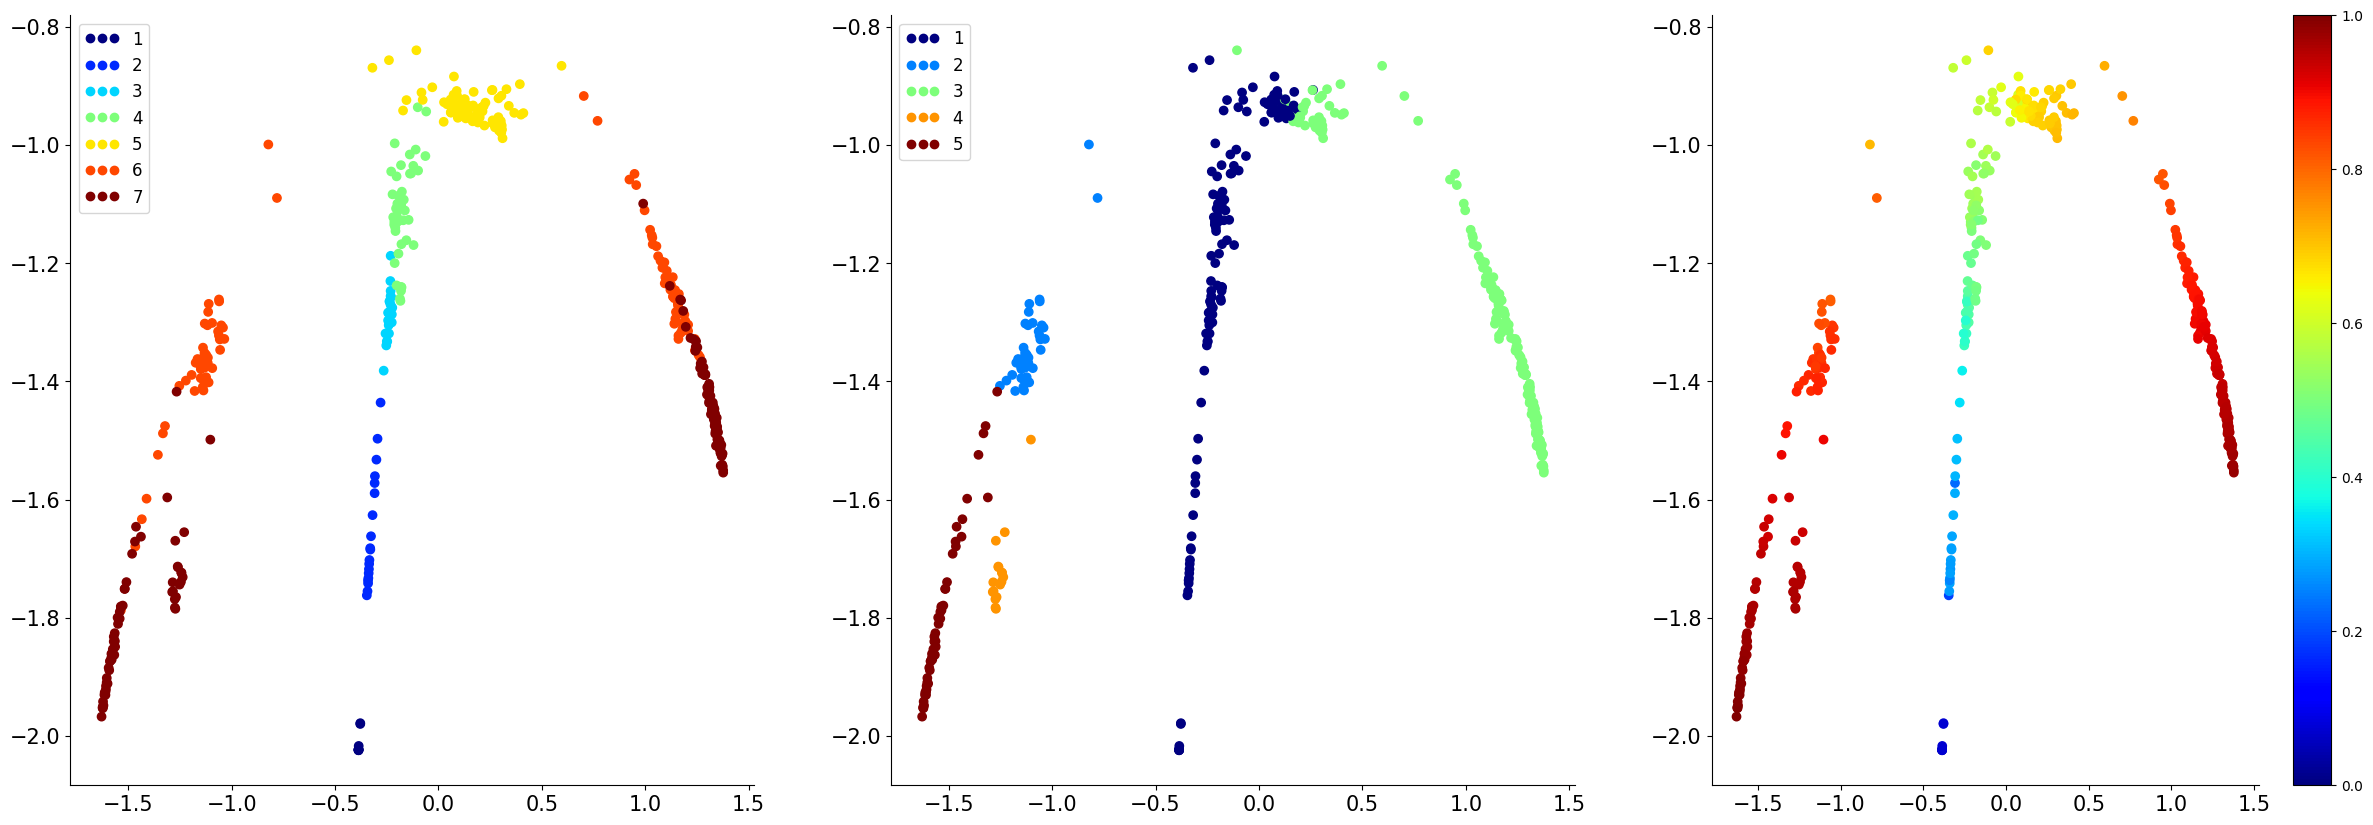

In [60]:
dims=[0,1]
fig = plt.figure(figsize=(30,10))
# 子图1，2
# plt.subplot(141) 
# plt.scatter(dY[:,dims[0]],dY[:,dims[1]])


stages = ture_stage
time_stage = sorted(set(stages))
color_stage = cm.jet(np.linspace(0, 1, len(time_stage)))
color_dict = dict(zip(time_stage, color_stage[:len(time_stage)]))
sc_colors = [color_dict[cst] for cst in stages]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(131)  # 子图1阶段
plt.scatter(dY[:,dims[0]],dY[:,dims[1]], c=sc_colors)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# 计算伪时间
root_list = list(np.where(stages == 1)[0])
dtflowtimes = dz.get_dtflow_times(root_list)
np.savetxt("./result/2"+datasets_names+"_pseudo_times.csv",dtflowtimes,delimiter=',')
# z.plotY(size=(10,10),dims=[0,1],color ='dftime')

# 计算分支
branch = dz.get_branches(Num=11,delta = 0.9) # 1-11 12-112 #11, 12-112 

# 子图3，4
plt.subplot(133) 
p = plt.scatter(dY[:,dims[0]],dY[:,dims[1]], c= dtflowtimes, cmap='jet')
plt.colorbar(p)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
nums_branch = sorted(set(branch)) 
color_branch = cm.jet(np.linspace(0, 1, len(nums_branch)))
color_dict = dict(zip(nums_branch,color_branch[:len(nums_branch)]))
sc_colors = [color_dict[cst] for cst in branch]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.subplot(132)  # 子图2分支
plt.scatter(dY[:,dims[0]],dY[:,dims[1]], c=sc_colors)
plt.legend(markers, color_dict.keys(), loc=2, numpoints=3, fontsize="large")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 将横坐标和纵坐标的大小调大
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("./result/figure/2"+datasets_names+"_04DTFLOW.png")  #保存图片
plt.savefig("./result/pdf/2"+datasets_names+"_04DTFLOW.pdf")  #保存图片
plt.show()

In [ ]:
import scipy.stats

# Create two lists of random values
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# y = [2, 1, 2, 4.5, 7, 6.5, 6, 9, 9.5]
x = dftimes_ml
y = dftimes
z = dtflowtimes
ture_labels = ture_stage
print('Spearman rank correlation coefficient of '+datasets_names+'\n'+'ture_labels=stage'+'\n')
print(scipy.stats.pearsonr(ture_labels, x)[0])
print(scipy.stats.pearsonr(ture_labels, y)[0])
print(scipy.stats.pearsonr(ture_labels, z)[0])
# 0.9412443251336238
print(scipy.stats.spearmanr(ture_labels, x)[0])
print(scipy.stats.spearmanr(ture_labels, y)[0])
print(scipy.stats.spearmanr(ture_labels, z)[0])  # 记录点3

Spearman rank correlation coefficient of guo2010
ture_labels=stage

0.8610154537276349
0.9738520081919314
0.9824654286436713
0.9138432823757269
0.9325581917897708
0.9546116124551928
